# Query plan
For any lazy query Polars has both:

- a non-optimized plan with the set of steps code as we provided it and
- an optimized plan with changes made by the query optimizer

We can understand both the non-optimized and optimized query plans with visualization and by printing them as text.

Below we consider the following query:

In [20]:
import polars as pl

q1 = (
    pl.scan_csv("../../datasets/reddit.csv")
    .with_columns(pl.col("name").str.to_uppercase())
    .filter(pl.col("comment_karma") > 0)
)

print(q1.collect().head())

shape: (5, 6)
┌───────┬───────────────────────────┬─────────────┬────────────┬───────────────┬────────────┐
│ id    ┆ name                      ┆ created_utc ┆ updated_on ┆ comment_karma ┆ link_karma │
│ ---   ┆ ---                       ┆ ---         ┆ ---        ┆ ---           ┆ ---        │
│ i64   ┆ str                       ┆ i64         ┆ i64        ┆ i64           ┆ i64        │
╞═══════╪═══════════════════════════╪═════════════╪════════════╪═══════════════╪════════════╡
│ 6     ┆ TAOJIANLONG_JASONBROKEN   ┆ 1397113510  ┆ 1536527864 ┆ 4             ┆ 0          │
│ 17    ┆ SSAIG_JASONBROKEN         ┆ 1397113544  ┆ 1536527864 ┆ 1             ┆ 0          │
│ 19    ┆ FDBVFDSSDGFDS_JASONBROKEN ┆ 1397113552  ┆ 1536527864 ┆ 3             ┆ 0          │
│ 37    ┆ IHATEWHOWEARE_JASONBROKEN ┆ 1397113636  ┆ 1536527864 ┆ 61            ┆ 0          │
│ 77714 ┆ HOCKEYSCHTICK             ┆ 1137474000  ┆ 1536497404 ┆ 11104         ┆ 451        │
└───────┴───────────────────────────┴─────────

## Non-optimized query plan

### Graphviz visualization
To create visualizations of the query plan, Graphviz should be installed and added to your PATH.

First we visualize the non-optimized plan by setting `optimized=False`.

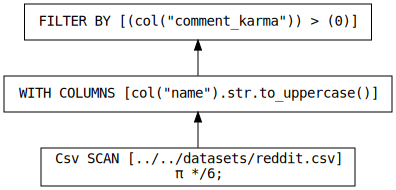

In [21]:
q1.show_graph(optimized=False)

The query plan visualization should be read from bottom to top. In the visualization:

- each box corresponds to a stage in the query plan
- the sigma stands for SELECTION and indicates any filter conditions
- the pi stands for PROJECTION and indicates choosing a subset of columns

### Printed query plan
We can also print the non-optimized plan with explain `(optimized=False)`

In [22]:
q1.explain(optimized=False)

'FILTER [(col("comment_karma")) > (0)]\nFROM\n   WITH_COLUMNS:\n   [col("name").str.to_uppercase()] \n    Csv SCAN [../../datasets/reddit.csv]\n    PROJECT */6 COLUMNS\n    ESTIMATED ROWS: 88'

The printed plan should also be read from bottom to top. This non-optimized plan is roughly equal to:

- read from the data/reddit.csv file
- read all 6 columns (where the * wildcard in PROJECT */6 COLUMNS means take all columns)
- transform the name column to uppercase
- apply a filter on the comment_karma column

## Optimized query plan
Now we visualize the optimized plan with `show_graph`.

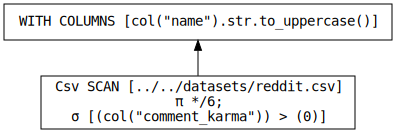

In [23]:
q1.show_graph()

In [25]:
print(q1.explain())

 WITH_COLUMNS:
 [col("name").str.to_uppercase()] 
  Csv SCAN [../../datasets/reddit.csv]
  PROJECT */6 COLUMNS
  SELECTION: [(col("comment_karma")) > (0)]
  ESTIMATED ROWS: 88


The optimized plan is to:

- read the data from the Reddit CSV
- apply the filter on the comment_karma column while the CSV is being read line-by-line
- transform the name column to uppercase

In this case the query optimizer has identified that the `filter` can be applied while the CSV is read from disk rather than reading the whole file into memory and then applying the filter. This optimization is called *Predicate* Pushdown.